<a href="https://colab.research.google.com/github/hargurjeet/hpe/blob/main/Problem1_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
!pip install pmdarima

In [70]:
## Importing all the requeired libraries

# For data preprocessing
import pandas as pd
import numpy as np
from collections import Counter
import datetime as dt

# To build visualizations
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats
import pylab

# Librareis for building pipelines
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

# Stats model to perfrom statistical analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# To build ML models
from fbprophet import Prophet
from matplotlib import pyplot as plt
import pandas.util.testing as tm
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb

In [71]:
df = pd.read_csv('https://raw.githubusercontent.com/hargurjeet/hpe/main/Problem1.csv')
df.head()

,SKU,DATE,#Units
0,SKU-01,Nov-11,"1,412"
1,SKU-01,Feb-12,915
2,SKU-01,May-12,"1,182"
3,SKU-01,Aug-12,"1,261"
4,SKU-01,Nov-12,"1,366"


In [72]:
df_sku_1=df[df.SKU=='SKU-01'].drop('SKU', axis=1)
df_sku_2=df[df.SKU=='SKU-02'].drop('SKU', axis=1)

In [90]:
df_sku_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DATE      13 non-null     object
 1    #Units   13 non-null     object
dtypes: object(2)
memory usage: 312.0+ bytes


In [74]:
# Function to convert Date to valid format

def data_converstion(df):
  # code block to type cast date column
  df[['Month','Year']] = df['DATE'].str.split('-',expand=True)
  df.Year = '20' + df.Year
  df['DATE'] = df.Month + '-' + df.Year 
  df.DATE = pd.to_datetime(df.DATE).dt.strftime('%d-%m-%Y')

  #Selecting only the required columns
  df = df[['DATE', ' #Units ']]

  #Setting the date column to be the index
  df.set_index("DATE", drop=False, inplace=True)
  df.rename(columns={' #Units ': 'Units_Sold'}, inplace=True)

  #Type casting the Units_sold column
  df['Units_Sold'] = df['Units_Sold'].str.replace(',', '').astype(int).apply(pd.to_numeric)
  return df

sku1 = data_converstion(df_sku_1)
sku2 = data_converstion(df_sku_2)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [75]:
sku1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, 01-11-2011 to 01-11-2014
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        13 non-null     object
 1   Units_Sold  13 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 312.0+ bytes


In [76]:
sku1

,DATE,Units_Sold
DATE,,
01-11-2011,01-11-2011,1412
01-02-2012,01-02-2012,915
01-05-2012,01-05-2012,1182
01-08-2012,01-08-2012,1261
01-11-2012,01-11-2012,1366
01-02-2013,01-02-2013,1227
01-05-2013,01-05-2013,919
01-08-2013,01-08-2013,612
01-11-2013,01-11-2013,642


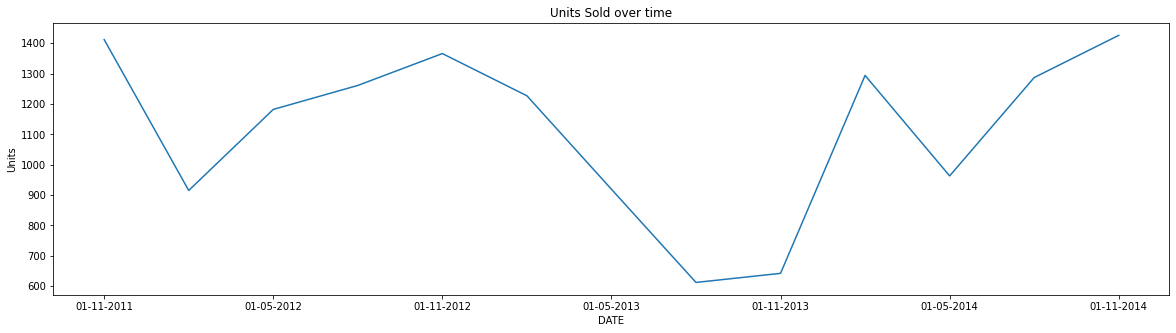

In [51]:
plt.rcParams['figure.figsize'] = (20, 5)
plt.title('Units Sold over time')
plt.ylabel('Units')
sku1.Units_Sold.plot() ;

In [52]:
# Stationary check

test_result=adfuller(sku1['Units_Sold'])

#Ho: Data is non stationary
#H1: Data is stationary

def adfuller_test(price):
    result=adfuller(price)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(sku1['Units_Sold'])


ADF Test Statistic : -1.6123273062919905
p-value : 0.47675401867532013
#Lags Used : 3
Number of Observations Used : 9
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [113]:
df_sku_1=df[df.SKU=='SKU-01'].drop('SKU', axis=1)

df_sku_1[['Month','Year']] = df_sku_1['DATE'].str.split('-',expand=True)
df_sku_1.Year = '20' + df_sku_1.Year
df_sku_1['DATE'] = df_sku_1.Month + '-' + df_sku_1.Year 
df_sku_1.DATE = pd.to_datetime(df_sku_1.DATE).dt.to_period('M')

In [114]:
df_sku_2 = df_sku_1[['DATE', ' #Units ']]

In [115]:
df_sku_2[' #Units '] = df[' #Units '].str.replace(',', '').astype(int).apply(pd.to_numeric)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [118]:
df_sku_2

,DATE,#Units
0,2011-11,1412
1,2012-02,915
2,2012-05,1182
3,2012-08,1261
4,2012-11,1366
5,2013-02,1227
6,2013-05,919
7,2013-08,612
8,2013-11,642
9,2014-02,1294


In [117]:
df_sku_2.set_index('DATE').resample('M').interpolate()

,#Units
DATE,
2011-11,1412.000000
2011-12,1246.333333
2012-01,1080.666667
2012-02,915.000000
2012-03,1004.000000
2012-04,1093.000000
2012-05,1182.000000
2012-06,1208.333333
2012-07,1234.666667


In [119]:
df_sku_3 = df_sku_2.set_index('DATE').resample('M').interpolate()

In [120]:
df_sku_3

,#Units
DATE,
2011-11,1412.000000
2011-12,1246.333333
2012-01,1080.666667
2012-02,915.000000
2012-03,1004.000000
2012-04,1093.000000
2012-05,1182.000000
2012-06,1208.333333
2012-07,1234.666667


In [121]:
## Implementing Shift

df_sku_3['Units_Sold_diff']=df_sku_3[' #Units ']-df_sku_3[' #Units '].shift(1)

In [129]:
df_sku_3['Seasonal_Difference']=df_sku_3[' #Units ']-df_sku_3[' #Units '].shift(3)


In [130]:
df_sku_3

,#Units,Units_Sold_diff,Seasonal_Difference
DATE,,,
2011-11,1412.000000,NaN,NaN
2011-12,1246.333333,-165.666667,NaN
2012-01,1080.666667,-165.666667,NaN
2012-02,915.000000,-165.666667,-497.000000
2012-03,1004.000000,89.000000,-242.333333
2012-04,1093.000000,89.000000,12.333333
2012-05,1182.000000,89.000000,267.000000
2012-06,1208.333333,26.333333,204.333333
2012-07,1234.666667,26.333333,141.666667


In [123]:
## Again test dickey fuller test
adfuller_test(df_sku_3['Units_Sold_diff'].dropna())

ADF Test Statistic : -1.9487720217807922
p-value : 0.3094762118449421
#Lags Used : 3
Number of Observations Used : 32
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


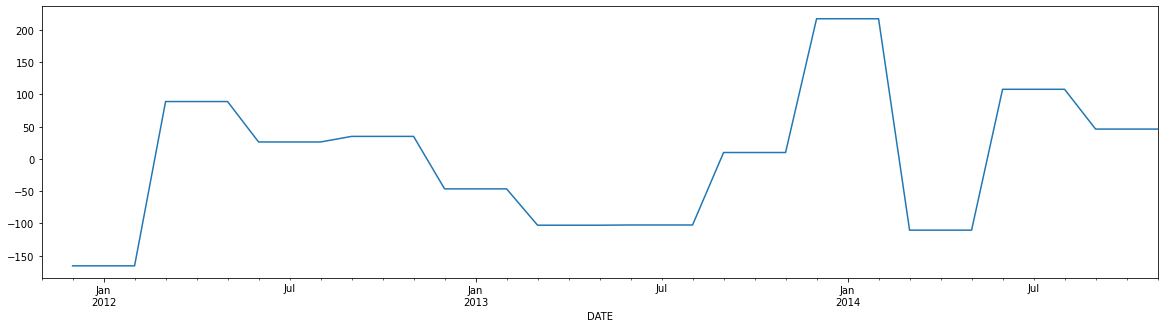

In [124]:
df_sku_3['Units_Sold_diff'].plot()

In [131]:
adfuller_test(df_sku_3['Seasonal_Difference'].dropna())

ADF Test Statistic : -1.89151554154127
p-value : 0.3360629343510173
#Lags Used : 7
Number of Observations Used : 26
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


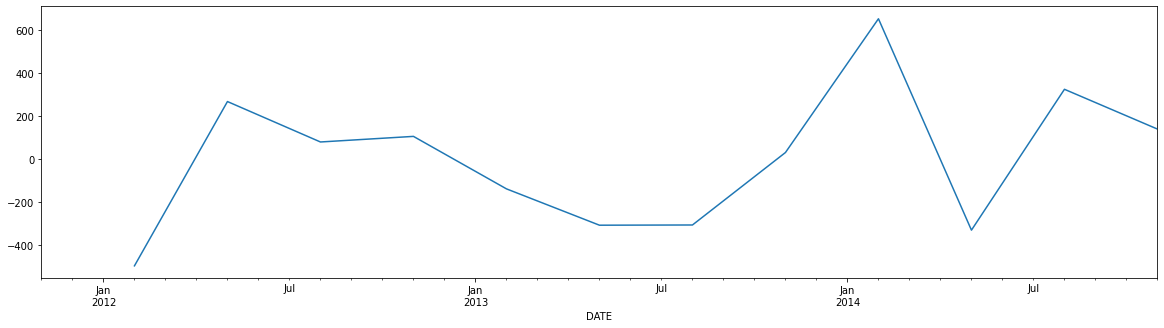

In [132]:
df_sku_3['Seasonal_Difference'].plot()

In [14]:
fig = go.Figure([go.Scatter(x=sku1.index,y=sku1.Units_Sold_diff)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    template='simple_white',
    title='difference VWAP over time ')
fig.show()

In [30]:
sku1

,Units_Sold,Units_Sold_diff
DATE,,
01-11-2011,1412,NaN
01-02-2012,915,-497.0
01-05-2012,1182,267.0
01-08-2012,1261,79.0
01-11-2012,1366,105.0
01-02-2013,1227,-139.0
01-05-2013,919,-308.0
01-08-2013,612,-307.0
01-11-2013,642,30.0


In [19]:
# Splitting training and testing set
df_train = sku1[sku1.index < '05-01-2014']
df_valid = sku1[sku1.index >= '05-01-2014']

In [20]:
df_train

,Units_Sold,Units_Sold_diff
DATE,,
01-11-2011,1412,NaN
01-02-2012,915,-497.0
01-05-2012,1182,267.0
01-08-2012,1261,79.0
01-11-2012,1366,105.0
01-02-2013,1227,-139.0
01-05-2013,919,-308.0
01-08-2013,612,-307.0
01-11-2013,642,30.0


In [21]:
df_valid

,Units_Sold,Units_Sold_diff
DATE,,
